In [1]:
import numpy as np
import matplotlib.pyplot as plt

# fitness function

- $c_{fr}$ : follow rail coefficient
- $c_{s}$ : safety coefficient
- $c_{pc}$ : pedestrian coefficient
- $c_{t}$ : trajectory coefficient

$$
f = c_{fr} \cdot R_c + c_{s} \cdot R_s + c_{pc} \cdot R_{pc} + c_{t} \cdot R_t
$$

$f \in [-4,4]$


### Rail following
- $d_p$ : penalty distance
- $d$ : distance between the train and the rail

$$
R_c = 1-\frac{2}{1+e^{-d + d_p}}
$$

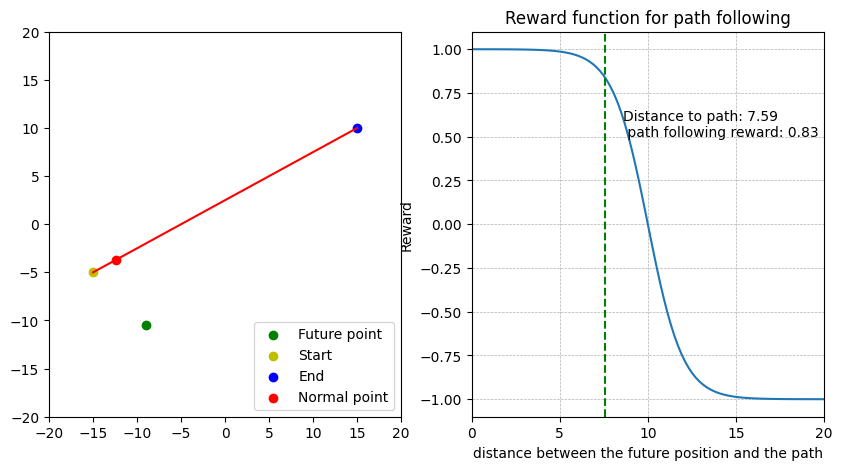

In [2]:
max_distance_display = 20
d = np.linspace(0, max_distance_display, 100)
penalty_distance = 10
Rc = 1-2 / (1 + np.exp(-d + penalty_distance))
fig , ax = plt.subplots(1, 2 , figsize=(10, 5))

ax[1].plot(d, Rc)
ax[1].set_xlabel('distance between the future position and the path')
ax[1].set_ylabel('Reward')
ax[1].set_title('Reward function for path following')
ax[1].xaxis.set_ticks(np.arange(0, max_distance_display+1, 5))
ax[1].grid(True, linewidth=0.5, linestyle='--')
ax[1].set_xlim(0, max_distance_display)
ax[1].set_ylim(-1.1, 1.1)

path = np.array([[-15, -5], [15, 10]])
futur_point = np.random.uniform(-15, 15, 2)
# vector a is start point to futur point
a = futur_point - path[0]
# vector b is start point to end point
b = path[1] - path[0]
# d is the product of the magnitude of a and cos of the angle between a and b
d = np.linalg.norm(a) * np.cos(np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))))
normal_point = path[0] + d * b / np.linalg.norm(b)
distance_to_rail = np.linalg.norm(futur_point - normal_point)
Rc = 1 - 2 / (1 + np.exp(-distance_to_rail + penalty_distance))
ax[1].axvline(distance_to_rail, color='g', linestyle='--')
ax[1].annotate(f'Distance to path: {distance_to_rail:.2f}\n path following reward: {Rc:.2f}',
                (distance_to_rail + 1, 0.5))

ax[0].plot(path[:, 0], path[:, 1], 'r')
ax[0].scatter(futur_point[0], futur_point[1], c='g', label='Future point')
ax[0].scatter(path[0, 0], path[0, 1], c='y', label='Start') 
ax[0].scatter(path[1, 0], path[1, 1], c='b', label='End')
ax[0].scatter(normal_point[0], normal_point[1], c='r', label='Normal point')
ax[0].set_xlim(-20, 20)
ax[0].set_ylim(-20, 20)
ax[0].legend(loc='lower right')

plt.show()

### Motion safety
- $eval_{radius}$ : evaluation radius
- $nb_{p}$ : number of pedestrians in the evaluation radius
- $d_i$ : distance between the vehicle and the i-th pedestrian
- $d_p$ : penalty distance


$$
S_c = -1 + \frac{2}{1+e^{-\frac{\sum_{i=1}^{nb_{p}}d_i}{d_i} + d_p}}
$$

or 

$$
S_c = -1 + \frac{2}{1+e^{-\bar{d_i} + d_p}}
$$

Lowess distance: 1.20
Mean distance: 9.14


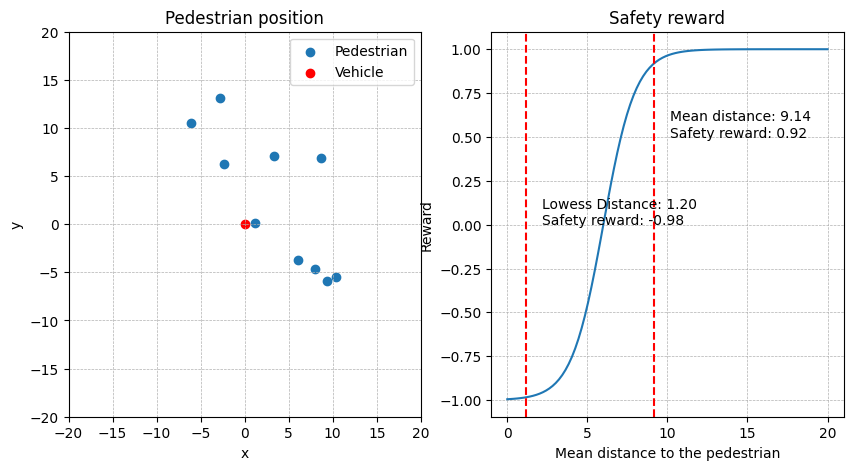

In [3]:
def safety_reward(distance, penalty_distance):
    return 2 / (1 + np.exp(-distance + penalty_distance)) - 1

eval_radius = 20
nb_pedestrian = 10
mu = 2.5 # in meter
# radom direction from the vehicle
random_vector = np.random.uniform(-np.pi, np.pi, (2, nb_pedestrian))
random_vector = np.array([np.cos(random_vector[0]), np.sin(random_vector[1])])
# normalize the vector
random_vector /= np.linalg.norm(random_vector, axis=0)
# random distance
d = np.random.randn(nb_pedestrian) * mu + eval_radius/2
# random position
pedestrian_pos = d * random_vector

penalty_distance = 6
mean_distance = np.mean(d)
lowess_distance = d[np.argmin(np.abs(d))]

print(f'Lowess distance: {lowess_distance:.2f}\nMean distance: {mean_distance:.2f}')
linspace_distance = np.linspace(0, eval_radius, 100)
Sc = safety_reward(linspace_distance, penalty_distance)

fig, axe = plt.subplots(1, 2, figsize=(10, 5))

axe[0].scatter(pedestrian_pos[0], pedestrian_pos[1], label='Pedestrian')
axe[0].scatter(0, 0, c='r', label='Vehicle')
axe[0].set_title('Pedestrian position')
axe[0].set_xlabel('x')
axe[0].set_ylabel('y')
axe[0].grid(True, linewidth=0.5, linestyle='--')
axe[0].legend()
axe[0].set_xlim(-eval_radius, eval_radius)
axe[0].set_ylim(-eval_radius, eval_radius)

axe[1].plot(linspace_distance, Sc)
axe[1].set_title('Safety reward')
axe[1].set_xlabel('Mean distance to the pedestrian')
axe[1].set_ylabel('Reward')
axe[1].grid(True, linewidth=0.5, linestyle='--')
axe[1].axvline(mean_distance, color='r', linestyle='--', label='Mean distance')
axe[1].annotate(f'Mean distance: {mean_distance:.2f}\nSafety reward: {safety_reward(mean_distance,penalty_distance):.2f}',
                (mean_distance + 1, 0.5))
axe[1].axvline(lowess_distance, color='r', linestyle='--', label='Lowess distance')
axe[1].annotate(f'Lowess Distance: {lowess_distance:.2f}\nSafety reward: {safety_reward(lowess_distance,penalty_distance):.2f}',
                (lowess_distance + 1, 0.0))

plt.show()

### Trajectory Quality
- $|a|$ : magnitude of the acceleration
- $m_0$ : magniture zero limit


$$
|a| = \sqrt{\frac{dx^2}{dt^2} + \frac{dy^2}{dt^2}}
$$

$$
T_c = 1 - \frac{2}{1+e^{-|a| + m_0}}
$$

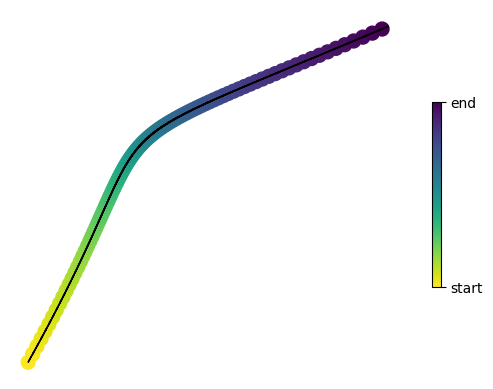

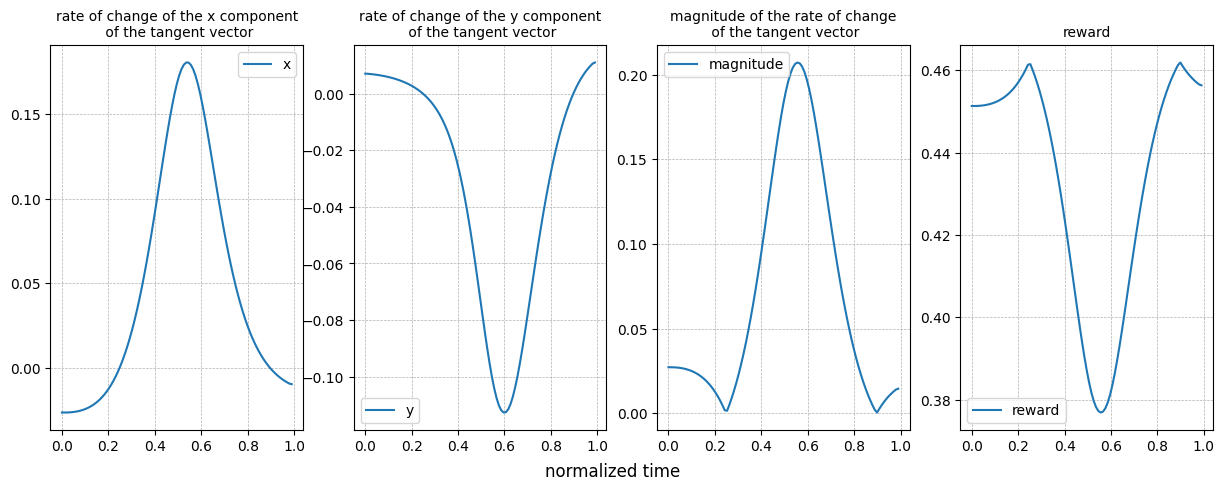

In [4]:
def lerp (a, b ,t):
    return a*(1-t) + b*t

# np.random.seed(42)

P1 = np.random.randn(2)
P2 = np.random.randn(2)
P3 = np.random.randn(2)
P4 = np.random.randn(2)

n = 100

l = np.linspace(0, 1, n).reshape(-1, 1)

P5 = lerp(P1, P2, l)
P6 = lerp(P2, P3, l)
P7 = lerp(P3, P4, l)
P8 = lerp(P5, P6, l)
P9 = lerp(P6, P7, l)
P10 = lerp(P8, P9, l)

# the tangent vector at each point
tangent = np.diff(P10, axis=0)
# normalize the tangent
tangent = tangent / np.linalg.norm(tangent, axis=1).reshape(-1, 1)
tangent *= 0.1


plt.scatter(P10[:, 0], P10[:, 1], c=l.flatten(), cmap = 'viridis_r', label='v',s=100)
for i in range(len(P10) - 1):
    plt.arrow(P10[i, 0], P10[i, 1], tangent[i, 0], tangent[i, 1])
plt.axis('off')
clor = plt.colorbar(shrink=0.5)
clor.set_ticks([0, 1])
clor.set_ticklabels(['start', 'end'])

plt.show()
dxdl = np.gradient(tangent[:, 0], l[:-1].flatten())
dydl = np.gradient(tangent[:, 1], l[:-1].flatten())


magnitude_roc = np.sqrt(dxdl**2 + dydl**2)
esp = 0.0001
# reward  = 1 / (magnitude_roc + esp)
maginture_zero_limit = 1
reward = -2 / (1 + np.exp(-magnitude_roc + maginture_zero_limit)) +1

fig, axe = plt.subplots(1, 4, figsize=(15, 5))
axe[0].plot(l[:-1], dxdl, label='x')
axe[0].set_title('rate of change of the x component\n of the tangent vector', fontsize=10)
axe[0].grid(True, linewidth=0.5, linestyle='--')
axe[0].legend()


axe[1].plot(l[:-1], dydl, label='y')
axe[1].set_title('rate of change of the y component\n of the tangent vector', fontsize=10)
axe[1].grid(True, linewidth=0.5, linestyle='--')
axe[1].legend()

axe[2].plot(l[:-1], magnitude_roc, label='magnitude')
axe[2].set_title('magnitude of the rate of change\n of the tangent vector', fontsize=10)
axe[2].grid(True, linewidth=0.5, linestyle='--')
axe[2].legend()

axe[3].plot(l[:-1], reward, label='reward')
axe[3].set_title('reward', fontsize=10)
axe[3].grid(True, linewidth=0.5, linestyle='--')
axe[3].legend()
fig.supxlabel('normalized time')

plt.show()

# plt.plot(tangent[:, 0], tangent[:, 1])
# plt.scatter(0, 0, c='r', label='start')
# plt.show()

### Pedestrian Comfort
- $\bar{I}_{ucf}$ : frequency of the linear velocity change a pedestrian experienced during the navigation
- $f_0$ : frequency zero penalmagniture


$$
T_c = 1 - \frac{2}{1+e^{10(-\bar{I}_{ucf} + m_0)}}
$$

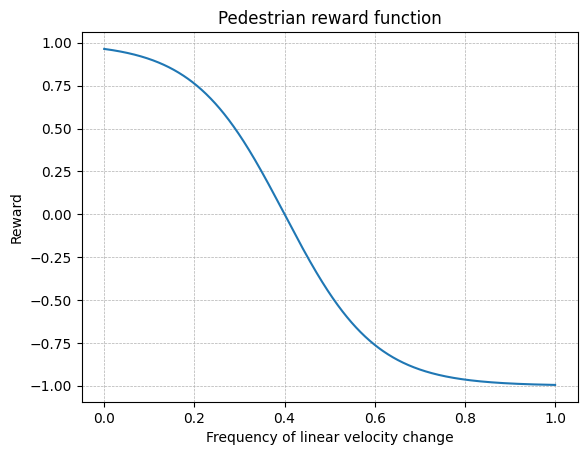

In [5]:
freq_domain = np.linspace(0, 1, 1000)
freq_penalty = 0.4

Pc = -2 / (1 + np.exp(10*(-freq_domain + freq_penalty))) + 1

plt.plot(freq_domain, Pc)
plt.xlabel('Frequency of linear velocity change')
plt.ylabel('Reward')
plt.title('Pedestrian reward function')
plt.grid(True, linewidth=0.5, linestyle='--')
plt.show()


## pedestrian density

In [6]:
nb_pedestrian = 30
pedestrian_pos = np.random.uniform(-20, 20, (2, nb_pedestrian))
density_grid = np.zeros((80, 80))
for i in range(pedestrian_pos.shape[1]):
    x = int((pedestrian_pos[0, i] + 20) * 2)
    y = int((pedestrian_pos[1, i] + 20) * 2)
    density_grid[x, y] += np.exp(-np.linalg.norm([x, y] - pedestrian_pos[:, i]))
density_grid /= nb_pedestrian
density_grid = np.rot90(density_grid)


In [7]:
nb_pedestrian = 100
pedestrian_pos = np.random.uniform(-20, 20, (2, nb_pedestrian))
density_grid = np.zeros((100, 100))
for i in range(density_grid.shape[0]):
    for j in range(density_grid.shape[1]):
        x = -20 + i * 0.4
        y = -20 + j * 0.4
        for k in range(nb_pedestrian):
            density_grid[i, j] += np.exp(-np.linalg.norm([x, y] - pedestrian_pos[:, k]))
density_grid /= nb_pedestrian
density_grid = np.rot90(density_grid)


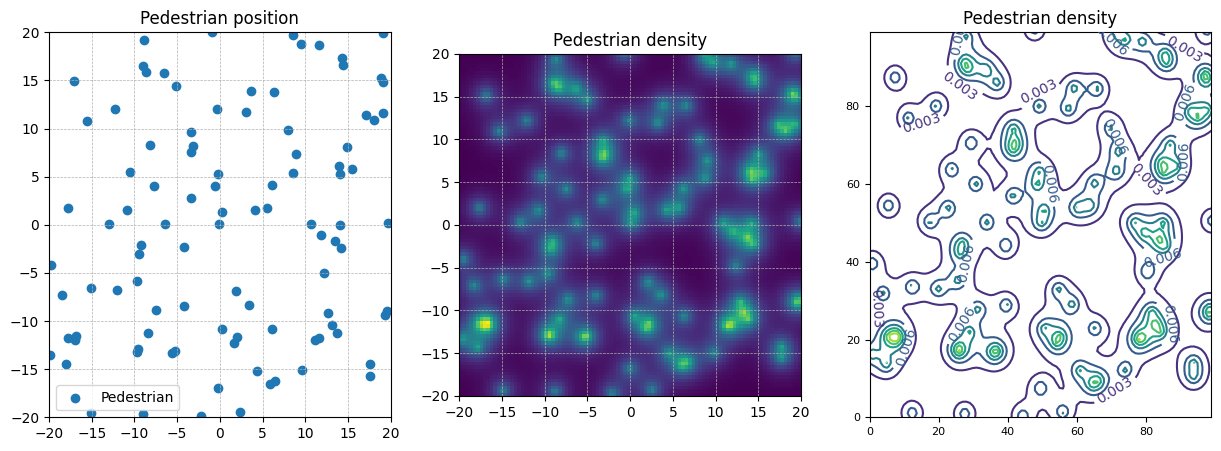

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(pedestrian_pos[0], pedestrian_pos[1], label='Pedestrian')
ax[0].set_xlim(-20, 20)
ax[0].set_ylim(-20, 20)
ax[0].set_title('Pedestrian position')
ax[0].grid(True, linewidth=0.5, linestyle='--')
ax[0].legend()

ax[1].imshow(density_grid, cmap='viridis', extent=(-20, 20, -20, 20))
ax[1].set_xlim(-20, 20)
ax[1].set_ylim(-20, 20)
ax[1].set_title('Pedestrian density')
ax[1].grid(True, linewidth=0.5, linestyle='--')

density_grid = np.rot90(density_grid.T)
cs = plt.contour(density_grid, cmap='viridis')
ax[2].clabel(cs, inline=1, fontsize=10)
# ax[2].axis('off')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('Pedestrian density')
plt.show()


In [9]:
occupancy_grid = np.zeros((16, 16))
nb_pedestrian = 100
pedestrian_pos = np.random.uniform(-20, 20, (2, nb_pedestrian))

for i in range(pedestrian_pos.shape[1]):
    x = int((pedestrian_pos[0, i] + 20) // 3)
    y = int((pedestrian_pos[1, i] + 20) // 3)
    occupancy_grid[x, y] += 1

occupancy_grid = np.rot90(occupancy_grid)

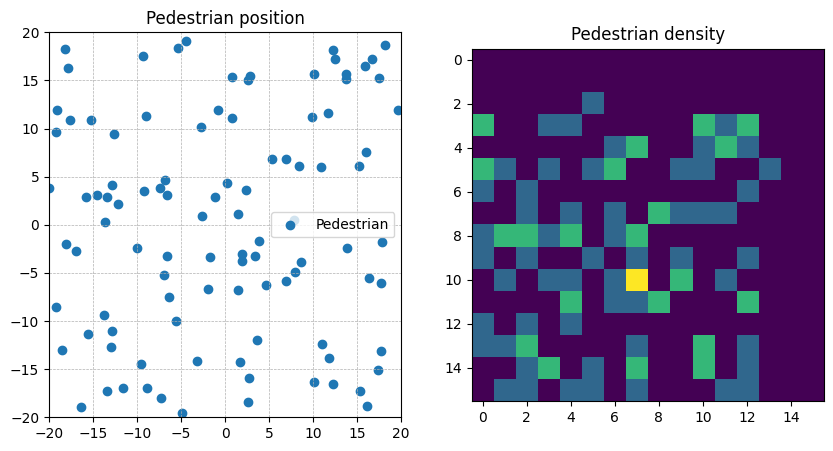

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(pedestrian_pos[0], pedestrian_pos[1], label='Pedestrian')
ax[0].set_xlim(-20, 20)
ax[0].set_ylim(-20, 20)
ax[0].set_title('Pedestrian position')
ax[0].grid(True, linewidth=0.5, linestyle='--')
ax[0].legend()

ax[1].imshow(occupancy_grid, cmap='viridis', interpolation='nearest')
ax[1].set_title('Pedestrian density')
# ax[1].grid(True, linewidth=0.5, linestyle='--')
plt.show()

## Senarios:

In [11]:
from numpy.linalg import inv, det

def normale_bidim(x, mu, Sig):
    """array(float) x array(float) x array(float) -> float"""
    #Dimension
    N = 2
    return (1/((2 * np.pi) ** (N/2) * det(Sig) ** 0.5)) * np.exp(-0.5 * (x - mu) @ inv(Sig) @ np.transpose(x - mu))

def plot_norm_2D(mu, Sig, bounds_min = np.array([-5, -5]), bounds_max = np.array([5, 5])):
    ngrid = 30
    x = np.linspace(bounds_min[0], bounds_max[0], ngrid)
    y = np.linspace(bounds_min[1], bounds_max[1], ngrid)
    X,Y = np.meshgrid(x,y)
    Z = np.array([normale_bidim(np.array([x,y]), mu, Sig) 
                  for x,y in zip(X.flatten(), Y.flatten())]).reshape(ngrid, ngrid)
    fig = plt.gcf() # recuperation de la figure courante
    ax = fig.gca()
    ax.contour(X,Y,Z)

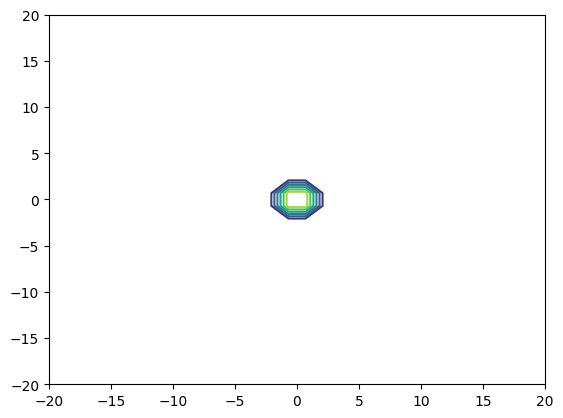

In [12]:
bounds_min = np.array([-20, -20])
bounds_max = np.array([20, 20])

nb_pedestrian = 30
pedestian_pos = np.random.uniform(-20, 20, (2, nb_pedestrian))

plt.figure()
mu = np.array([0, 0])
Sig = np.array([[1, 0], [0, 1]])
plot_norm_2D(mu, Sig, bounds_min, bounds_max)
plt.show()

## Discount factor

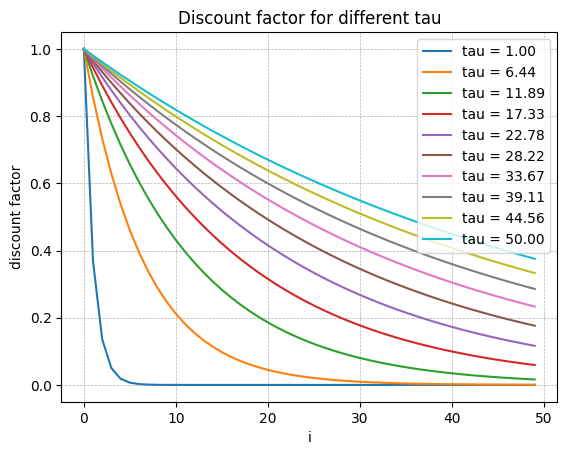

In [138]:
i = np.arange(0, 50)
tau = np.linspace(1, 50, 10).reshape(-1, 1)
l = np.exp(-i / tau)
for j in range(l.shape[0]):
    plt.plot(l[j], label=f'tau = {tau[j][0]:.2f}')
plt.xlabel('i')
plt.ylabel('discount factor')
plt.title('Discount factor for different tau')
plt.legend()
plt.grid(True, linewidth=0.5, linestyle='--')
plt.show()

# Reward Function:

$$
R = r_c + r_{nc} + r_{s} + r_p
$$
- $r_c$ : collision reward, to punish the agent for colliding with the pedestrian. $r_c >>$ other rewards signals
- $r_{nc}$ : near collision reward, to punish the agent for getting too close to the pedestrian. Not just a discrete reward, but a continuous one, to encourage the agent to keep a safe distance from the pedestrian but not prevent it from getting close to the pedestrian.
- $r_s$ : speed reward, to reward the agent for moving fast/to the preferred speed. This is to encourage the agent to move at a reasonable speed, but not too fast or too slow.
- $r_p$ : path following reward, to reward the agent for following the path. This is to encourage the agent to follow the path, but not to prevent it from deviating from the path if necessary.

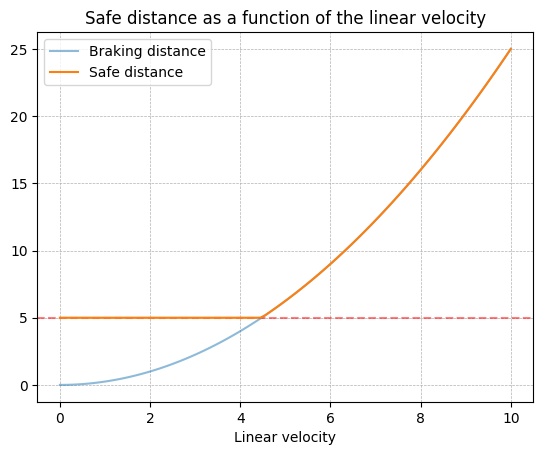

In [64]:
n = 100
v_ev = np.linspace(0, 10, n)
a_max = 2
min_safe_distance = 5
do = np.ones(n) * min_safe_distance
dr = np.maximum(np.power(v_ev,2) / (2 * a_max), do)

plt.axhline(min_safe_distance, color='r', linestyle='--', alpha=0.5)
plt.plot(v_ev, np.power(v_ev,2) / (2 * a_max), label='Braking distance', alpha=0.5)
plt.plot(v_ev, dr, label='Safe distance')
plt.xlabel('Linear velocity')
plt.title('Safe distance as a function of the linear velocity')
plt.grid(True, linewidth=0.5, linestyle='--')
plt.legend()

plt.show()

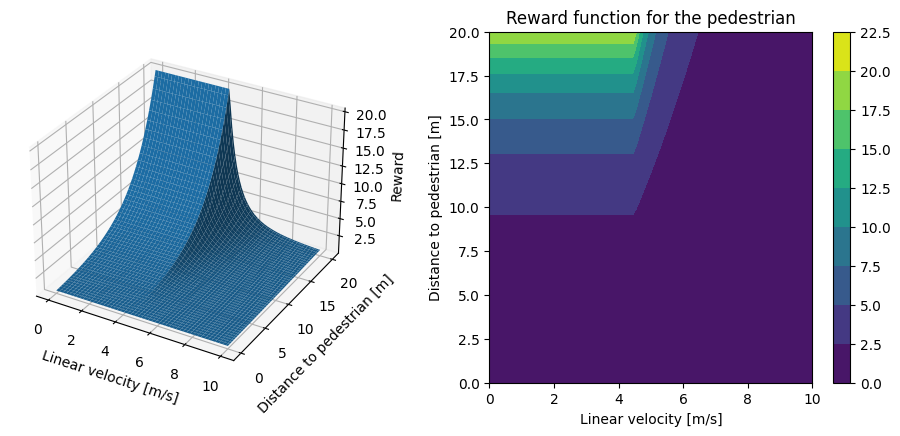

In [68]:
distance_pedesrian = np.linspace(0, 20, n).reshape(-1, 1)
r_nc = np.exp((distance_pedesrian-dr)/dr) 
# print(r_nc.shape)

#3D plot
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(v_ev, distance_pedesrian, r_nc)
ax.set_xlabel('Linear velocity [m/s]')
ax.set_ylabel('Distance to pedestrian [m]')
ax.set_zlabel('Reward')

#2D plot
ax = fig.add_subplot(122)
coutour = ax.contourf(v_ev.flatten(), distance_pedesrian.flatten(), r_nc)
ax.set_xlabel('Linear velocity [m/s]')
ax.set_ylabel('Distance to pedestrian [m]')
ax.set_title('Reward function for the pedestrian')

fig.colorbar(coutour)
fig.tight_layout(pad=3)
plt.show()


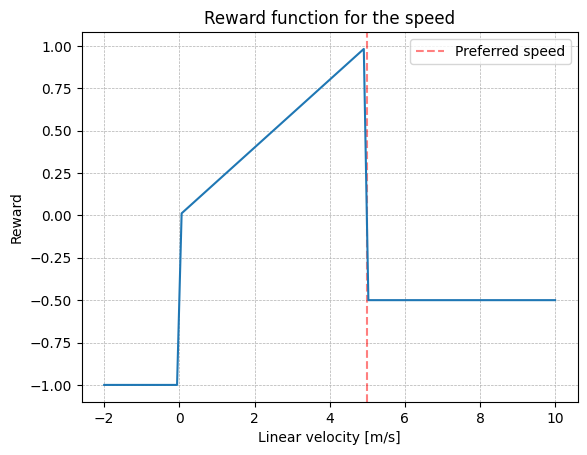

In [184]:
def speed_reward(current_speed, pref_speed):
    if 0.0 < current_speed <= pref_speed:
        l = 1/pref_speed # old formula
        # return l * (pref_speed - current_speed)
        return 1-(pref_speed - current_speed)/pref_speed
    elif current_speed > pref_speed:
        return -0.5
    elif current_speed <= 0.0:
        return -1.0
    
    
v_ev = np.linspace(-2, 10, n)

speed_function = np.vectorize(speed_reward)
pref_speed = 5
r_speed = speed_function(v_ev, pref_speed)

plt.axvline(pref_speed, color='r', linestyle='--', alpha=0.5, label='Preferred speed')
plt.plot(v_ev, r_speed)
plt.xlabel('Linear velocity [m/s]')
plt.ylabel('Reward')
plt.title('Reward function for the speed')
plt.grid(True, linewidth=0.5, linestyle='--')
plt.legend()

plt.show()

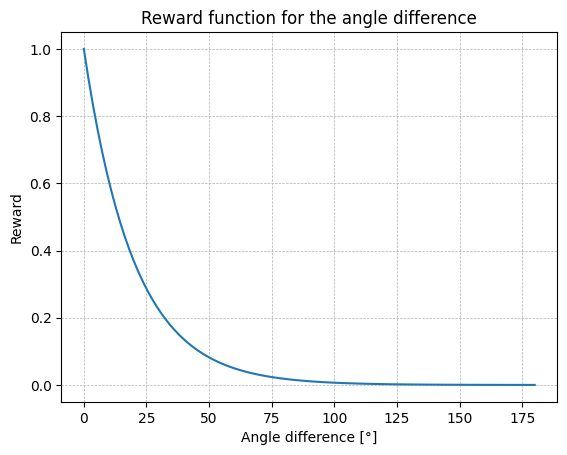

In [185]:
espison_theta = np.linspace(0, 180, n)

# r_p = 1/(espison_theta + 1)
r_p = np.exp(-espison_theta/20) 
plt.plot(espison_theta, r_p)
plt.xlabel('Angle difference [°]')
plt.ylabel('Reward')
plt.title('Reward function for the angle difference')
plt.grid(True, linewidth=0.5, linestyle='--')
plt.show()


In [183]:
a = np.array([1, 0])
b = np.array([0, 1])
cz = a[0] * b[1] - a[1] * b[0]
c = np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))) * np.sign(cz)
c = np.degrees(c)
c

90.0

In [190]:
def distance_from_path(point, path):
    a = point - path[0]
    b = path[1] - path[0]
    d = np.linalg.norm(a) * np.cos(np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))))
    normal_point = path[0] + d * b / np.linalg.norm(b)
    distance_to_rail = np.linalg.norm(point - normal_point)
    return distance_to_rail

In [203]:
def proximity_reward(distance, penalty_distance):
    return 1 - 2 / (1 + np.exp(-distance + penalty_distance))

(100, 100)


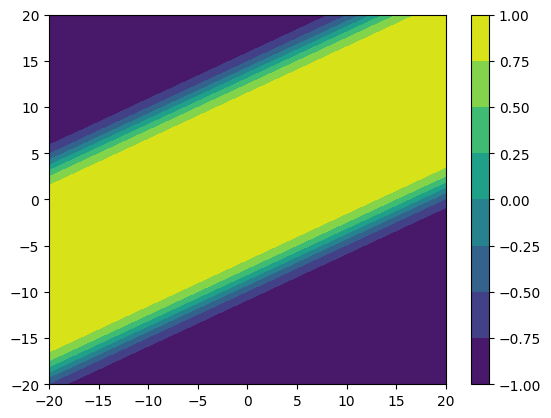

In [205]:
all_points = np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100))
print(all_points[0].shape)

plt.figure()
path = np.array([[-15, -5], [15, 10]])
distance = np.zeros(all_points[0].shape)
for i in range(all_points[0].shape[0]):
    for j in range(all_points[0].shape[1]):
        distance[i, j] = distance_from_path(np.array([all_points[0][i, j], all_points[1][i, j]]), path)
reward = proximity_reward(distance, 10)
# plt.imshow(reward, cmap='viridis', extent=(-20, 20, -20, 20))
plt.contourf(all_points[0], all_points[1], reward, cmap='viridis')
plt.colorbar()
plt.show()


(100, 100)


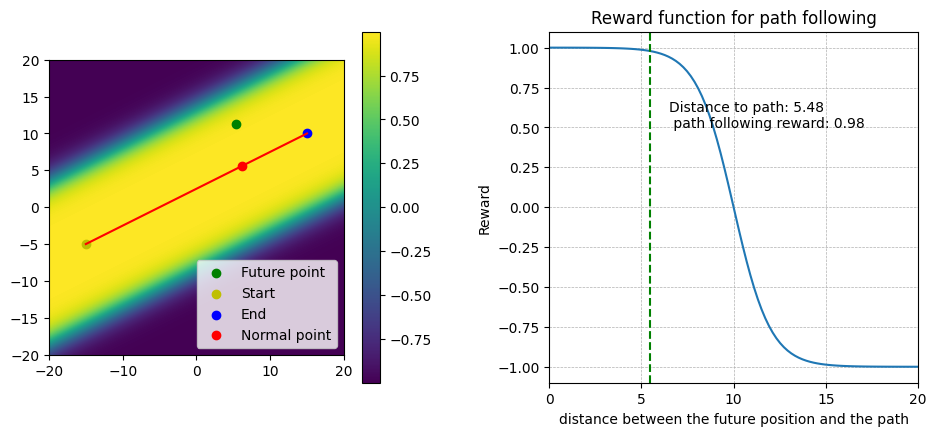

In [216]:
max_distance_display = 20
d = np.linspace(0, max_distance_display, 100)
penalty_distance = 10
Rc = 1-2 / (1 + np.exp(-d + penalty_distance))
fig , ax = plt.subplots(1, 2 , figsize=(10, 5))

ax[1].plot(d, Rc)
ax[1].set_xlabel('distance between the future position and the path')
ax[1].set_ylabel('Reward')
ax[1].set_title('Reward function for path following')
ax[1].xaxis.set_ticks(np.arange(0, max_distance_display+1, 5))
ax[1].grid(True, linewidth=0.5, linestyle='--')
ax[1].set_xlim(0, max_distance_display)
ax[1].set_ylim(-1.1, 1.1)

path = np.array([[-15, -5], [15, 10]])
futur_point = np.random.uniform(-15, 15, 2)
distance_to_rail = distance_from_path(futur_point, path)
Rc = 1 - 2 / (1 + np.exp(-distance_to_rail + penalty_distance))
ax[1].axvline(distance_to_rail, color='g', linestyle='--')
ax[1].annotate(f'Distance to path: {distance_to_rail:.2f}\n path following reward: {Rc:.2f}',
                (distance_to_rail + 1, 0.5))

all_points = np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100))
print(all_points[0].shape)

# path = np.array([[-15, -5], [15, 10]])
distance = np.zeros(all_points[0].shape)
for i in range(all_points[0].shape[0]):
    for j in range(all_points[0].shape[1]):
        distance[i, j] = distance_from_path(np.array([all_points[0][i, j], all_points[1][i, j]]), path)
reward = proximity_reward(distance, 10)
reward_img = ax[0].imshow(reward, cmap='viridis', extent=(-20, 20, -20, 20), origin='lower', interpolation='bilinear')
# plt.contourf(all_points[0], all_points[1], reward, cmap='viridis')
fig.colorbar(reward_img , ax=ax[0])

ax[0].plot(path[:, 0], path[:, 1], 'r')
ax[0].scatter(futur_point[0], futur_point[1], c='g', label='Future point')
ax[0].scatter(path[0, 0], path[0, 1], c='y', label='Start') 
ax[0].scatter(path[1, 0], path[1, 1], c='b', label='End')
ax[0].scatter(normal_point[0], normal_point[1], c='r', label='Normal point')
ax[0].set_xlim(-20, 20)
ax[0].set_ylim(-20, 20)
ax[0].legend(loc='lower right')
fig.tight_layout(pad=3)
plt.show()